# Variational Autoencoder (VAE) on MNIST

This notebook implements a basic VAE for MNIST (1×28×28) mirroring the structure and loss used in `VAE.ipynb`:
- Convolutional encoder/decoder
- Latent dimension: 64
- Reconstruction loss: MSE (sum) + KL divergence
- Device auto-detection (MPS/CUDA/CPU)

Run cells top to bottom to train and visualize reconstructions/samples.

In [2]:
# Imports and device
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt

# Select device (MPS > CUDA > CPU)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Reproducibility
torch.manual_seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(42)

Using device: mps


In [3]:
# Data: MNIST
batch_size = 128
num_workers = 2

data_root = os.path.join(os.getcwd(), '../../data')
os.makedirs(data_root, exist_ok=True)

transform = transforms.Compose([
    transforms.ToTensor(),              # [0,1]
    # Keep MNIST as 1x28x28; normalize to mean=0.5, std=0.5 -> [-1,1]
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
val_dataset   = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device.type!='cpu'))
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device.type!='cpu'))

len(train_dataset), len(val_dataset)

(60000, 10000)

In [4]:
# Align naming with CIFAR notebook and prepare fixed batch
# Use the validation loader as test_loader for MNIST
test_loader = val_loader

# Fixed batch for monitoring (images only)
fixed_batch = next(iter(test_loader))

/Users/zainali/Library/Python/3.13/lib/python/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [5]:
# VAE model for MNIST (1x28x28) mirroring CIFAR VAE structure where possible
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.latent_dim = latent_dim
        # Encoder: 1x28x28 -> 32x14x14 -> 64x7x7 -> flatten 3136
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 32x14x14
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 64x7x7
            nn.BatchNorm2d(64),
            nn.ReLU(True),
        )
        self.flatten_dim = 64 * 7 * 7
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder: latent -> 64x7x7 -> 32x14x14 -> 1x28x28
        self.decoder_input = nn.Linear(latent_dim, self.flatten_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x14x14
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # 1x28x28
            nn.Tanh()  # match normalized [-1,1]
        )

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 64, 7, 7)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

latent_dim = 64
model = VAE(latent_dim=latent_dim).to(device)
print(model)

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (fc_mu): Linear(in_features=3136, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=64, bias=True)
  (decoder_input): Linear(in_features=64, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)


In [6]:
# Loss function (MSE + KL) to match VAE.ipynb

def loss_function(recon_x, x, mu, logvar):
    # MSE reconstruction loss summed over elements
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    # KL divergence term
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

Batch: torch.Size([128, 1, 28, 28]) Recon: torch.Size([128, 1, 28, 28]) mu: torch.Size([128, 64]) logvar: torch.Size([128, 64])


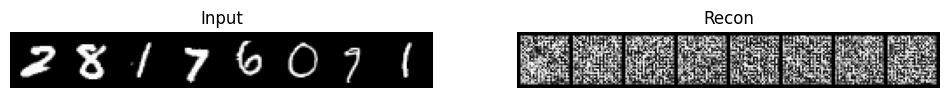

In [6]:
# Sanity check on one batch
xb, yb = next(iter(train_loader))
xb = xb.to(device)
with torch.no_grad():
    recon, mu, logvar = model(xb)
print("Batch:", xb.shape, "Recon:", recon.shape, "mu:", mu.shape, "logvar:", logvar.shape)

grid = vutils.make_grid(xb[:8].cpu(), nrow=8, normalize=True, value_range=(-1,1))
recon_grid = vutils.make_grid(recon[:8].cpu(), nrow=8, normalize=True, value_range=(-1,1))
plt.figure(figsize=(12,3))
plt.subplot(1,2,1); plt.title('Input'); plt.axis('off'); plt.imshow(grid.permute(1,2,0))
plt.subplot(1,2,2); plt.title('Recon'); plt.axis('off'); plt.imshow(recon_grid.permute(1,2,0))
plt.show()

In [7]:
# Training setup (mirroring structure from VAE.ipynb)
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
max_epochs = 30
checkpoint_dir = './checkpoints_mnist'
os.makedirs(checkpoint_dir, exist_ok=True)
recon_dir = './reconstructions_mnist'
os.makedirs(recon_dir, exist_ok=True)

# Resume from checkpoint if exists
start_epoch = 0
checkpoint_path = os.path.join(checkpoint_dir, 'vae_mnist_latest.pth')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Resuming from epoch {start_epoch}")

# Function to save reconstructions (MNIST single-channel handling)
def save_reconstructions(model, fixed_batch, epoch):
    model.eval()
    with torch.no_grad():
        # fixed_batch can be (images, labels) or images depending on creation
        if isinstance(fixed_batch, (list, tuple)):
            fixed_images = fixed_batch[0].to(device)
        else:
            fixed_images = fixed_batch.to(device)
        recon, _, _ = model(fixed_images)

        # Denormalize from [-1,1] -> [0,1]
        fixed_images_dn = fixed_images * 0.5 + 0.5
        recon_dn = recon * 0.5 + 0.5

        # Plot: show 8 originals and 8 reconstructions
        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            axes[0, i].imshow(fixed_images_dn[i].cpu().squeeze(0), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(recon_dn[i].cpu().squeeze(0), cmap='gray')
            axes[1, i].axis('off')
        axes[0, 0].set_title('Original')
        axes[1, 0].set_title('Reconstructed')
        out_path = os.path.join(recon_dir, f'recon_epoch_{epoch}.png')
        plt.savefig(out_path)
        plt.close()
    model.train()

# Training loop
for epoch in range(start_epoch, max_epochs):
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()

    # Average losses
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = train_recon_loss / len(train_loader.dataset)
    avg_kl_loss = train_kl_loss / len(train_loader.dataset)

    print(f'Epoch {epoch+1}/{max_epochs}, Total Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}')

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
        }, os.path.join(checkpoint_dir, f'vae_mnist_epoch_{epoch+1}.pth'))
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
        }, checkpoint_path)  # Latest checkpoint

    # Save reconstructions every 20 epochs (or first epoch for quick sanity)
    if (epoch + 1) % 20 == 0 or (epoch == 0):
        save_reconstructions(model, fixed_batch, epoch + 1)

print("Training completed!")

Resuming from epoch 30
Training completed!


✅ Model loaded from ./checkpoints_mnist/vae_mnist_epoch_30.pth (epoch 30)


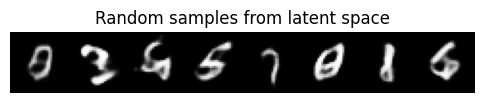

In [8]:
# Sampling from latent space and visualization
import glob
model = VAE(latent_dim=latent_dim).to(device)

checkpoint_files = glob.glob('./checkpoints_mnist/vae_mnist_epoch_*.pth')
if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    checkpoint = torch.load(latest_checkpoint, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Model loaded from {latest_checkpoint} (epoch {checkpoint['epoch']})")
else:
    print("❌ No MNIST checkpoint files found in ./checkpoints_mnist/")
    print("Run training first or adjust the path if you already trained.")
model.eval()
with torch.no_grad():
    z = torch.randn(8, latent_dim, device=device)
    samples = model.decode(z)
    grid = vutils.make_grid(samples.cpu(), nrow=8, normalize=True, value_range=(-1,1))
plt.figure(figsize=(6,6))
plt.title('Random samples from latent space')
plt.axis('off')
plt.imshow(grid.permute(1,2,0))
plt.show()

In [9]:
# Load latest MNIST checkpoint and evaluate on test_loader
import glob

model = VAE(latent_dim=latent_dim).to(device)

checkpoint_files = glob.glob('./checkpoints_mnist/vae_mnist_epoch_*.pth')
if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    checkpoint = torch.load(latest_checkpoint, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Model loaded from {latest_checkpoint} (epoch {checkpoint['epoch']})")
else:
    print("❌ No MNIST checkpoint files found in ./checkpoints_mnist/")
    print("Run training first or adjust the path if you already trained.")

model.eval()
test_loss, recon_loss, kl_loss = 0, 0, 0
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        recon, mu, logvar = model(x)
        loss, recon_b, kl_b = loss_function(recon, x, mu, logvar)
        test_loss += loss.item()
        recon_loss += recon_b.item()
        kl_loss += kl_b.item()

n = len(test_loader.dataset)
print(f"Avg Test Loss: {test_loss/n:.4f}, Recon: {recon_loss/n:.4f}, KL: {kl_loss/n:.4f}")

✅ Model loaded from ./checkpoints_mnist/vae_mnist_epoch_30.pth (epoch 30)
Avg Test Loss: 60.1467, Recon: 29.5211, KL: 30.6256


/Users/zainali/Library/Python/3.13/lib/python/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


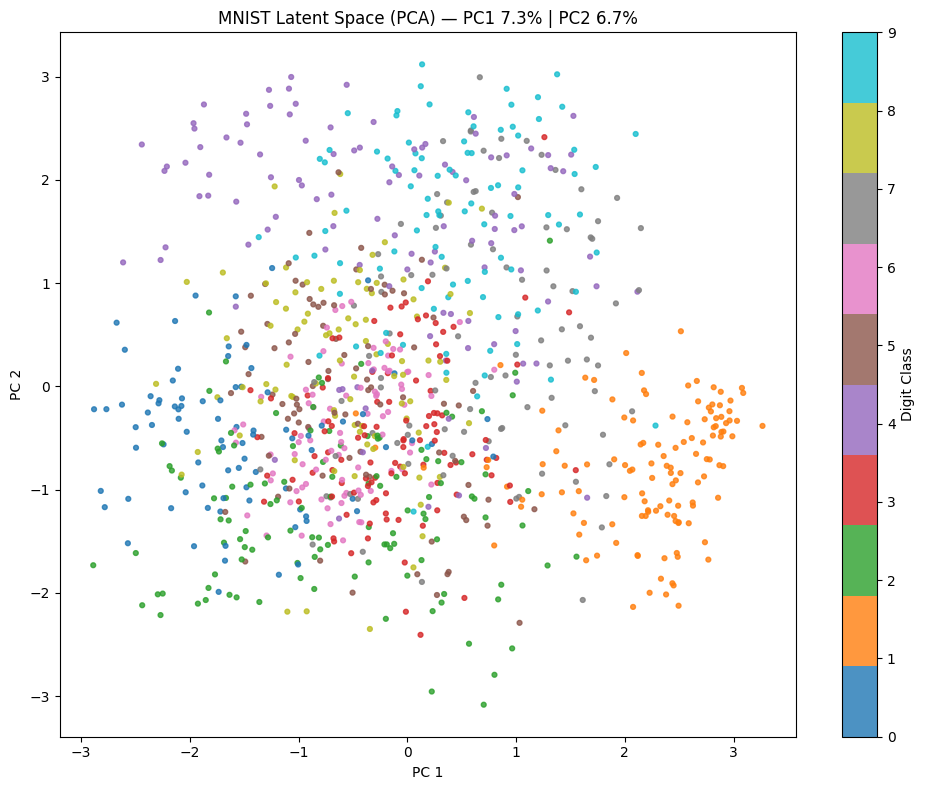

In [10]:
# Latent space visualization for MNIST (PCA by default)
from sklearn.decomposition import PCA
import numpy as np

model.eval()
latents, labels = [], []
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        mu, _ = model.encode(data)
        latents.append(mu.cpu().numpy())
        labels.append(target.numpy())
        if len(latents) * batch_size >= 1000:
            break

latents = np.concatenate(latents)[:1000]
labels = np.concatenate(labels)[:1000]

pca = PCA(n_components=2, random_state=42)
lat2d = pca.fit_transform(latents)

plt.figure(figsize=(10,8))
sc = plt.scatter(lat2d[:,0], lat2d[:,1], c=labels, cmap='tab10', s=12, alpha=0.8)
plt.title(f'MNIST Latent Space (PCA) — PC1 {pca.explained_variance_ratio_[0]*100:.1f}% | PC2 {pca.explained_variance_ratio_[1]*100:.1f}%')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(sc, ticks=range(10))
cb.set_label('Digit Class')
plt.tight_layout()
plt.show()

Found 2 saved reconstruction files


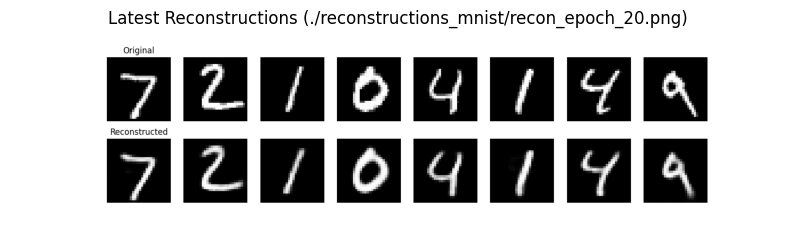

In [11]:
# Display saved reconstructions for MNIST
import glob
from PIL import Image

recon_files = sorted(glob.glob('./reconstructions_mnist/recon_epoch_*.png'))
if recon_files:
    print(f"Found {len(recon_files)} saved reconstruction files")
    latest_recon = recon_files[-1]
    img = Image.open(latest_recon)
    plt.figure(figsize=(10, 5))
    plt.imshow(img, cmap='gray')
    plt.title(f'Latest Reconstructions ({latest_recon})')
    plt.axis('off')
    plt.show()
else:
    print("No saved reconstruction files found. Run training first to generate them.")

/Users/zainali/Library/Python/3.13/lib/python/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


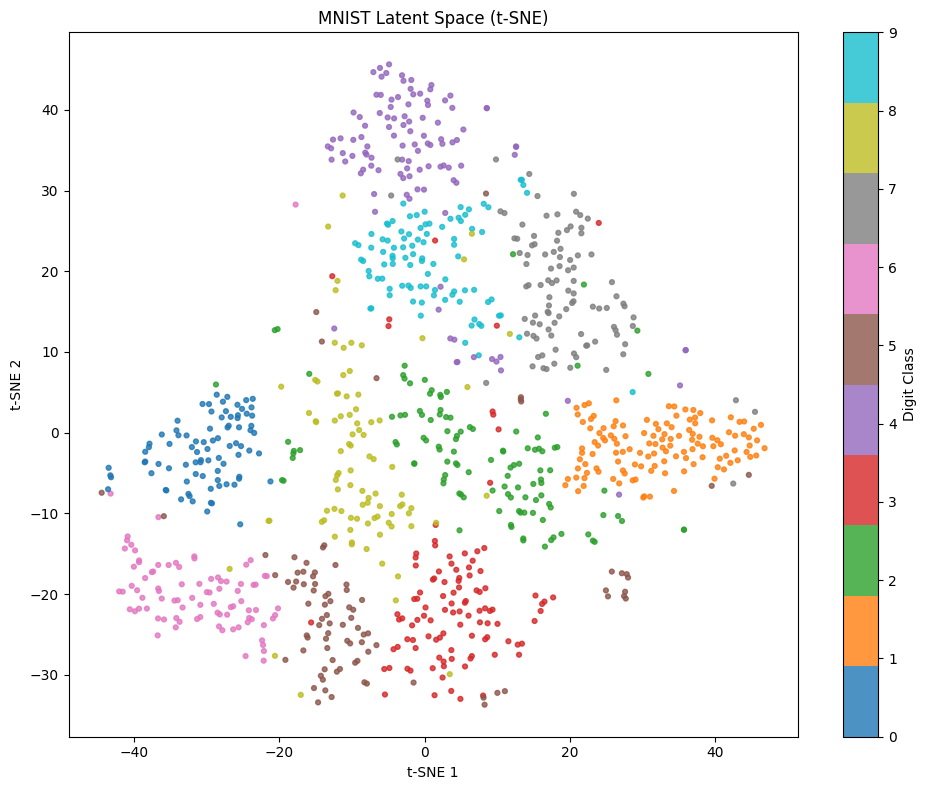

In [12]:
# Latent space visualization (t-SNE)
from sklearn.manifold import TSNE
import numpy as np

model.eval()
latents, labels = [], []
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        mu, _ = model.encode(data)
        latents.append(mu.cpu().numpy())
        labels.append(target.numpy())
        if len(latents) * batch_size >= 1000:
            break

latents = np.concatenate(latents)[:1000]
labels = np.concatenate(labels)[:1000]

# t-SNE to 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
lat2d_tsne = tsne.fit_transform(latents)

plt.figure(figsize=(10,8))
sc = plt.scatter(lat2d_tsne[:,0], lat2d_tsne[:,1], c=labels, cmap='tab10', s=12, alpha=0.8)
plt.title('MNIST Latent Space (t-SNE)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
cb = plt.colorbar(sc, ticks=range(10))
cb.set_label('Digit Class')
plt.tight_layout()
plt.show()

## Latent interpolation between two MNIST digits

This cell linearly interpolates between two latent vectors (means) encoded from chosen digits and decodes the intermediate points to visualize a smooth morph. It also saves the resulting grid image to `./interpolations_mnist/`.

Using checkpoint: ./checkpoints_mnist/vae_mnist_epoch_30.pth


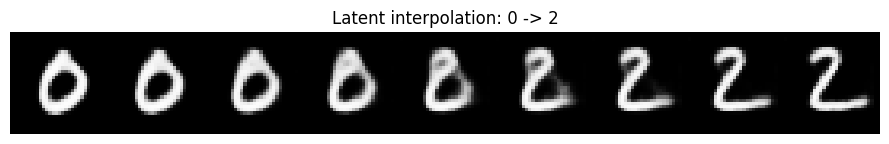

Saved: ./interpolations_mnist/interp_0_to_2.png


In [20]:
# Interpolate between two encoded images and decode the path
import os, glob, torch, numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import Image

# Ensure output dir
interp_dir = './interpolations_mnist'
os.makedirs(interp_dir, exist_ok=True)

# Reload a trained model if necessary (prefer latest epoch checkpoint)
try:
    checkpoint_files = glob.glob('./checkpoints_mnist/vae_mnist_epoch_*.pth')
    if checkpoint_files:
        latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
        _ckpt = torch.load(latest_checkpoint, map_location=device)
        model.load_state_dict(_ckpt['model_state_dict'])
        print(f"Using checkpoint: {latest_checkpoint}")
except Exception as e:
    print("Warning: could not load latest checkpoint:", e)

model.eval()

# Helper to get indices for two different target digits
def pick_two_digits(dataset, d1=3, d2=8):
    idx1 = idx2 = None
    for i in range(len(dataset)):
        img, lbl = dataset[i]
        if idx1 is None and lbl == d1:
            idx1 = i
        if idx2 is None and lbl == d2:
            idx2 = i
        if idx1 is not None and idx2 is not None:
            break
    return idx1, idx2

# Choose two digits to morph between (change d1/d2 as you like)
d1, d2 = 0, 2
idx1, idx2 = pick_two_digits(val_dataset, d1=d1, d2=d2)
if idx1 is None or idx2 is None:
    raise RuntimeError("Could not find the requested digits in the validation set.")

x1, y1 = val_dataset[idx1]
x2, y2 = val_dataset[idx2]
x1 = x1.unsqueeze(0).to(device)  # [1,1,28,28]
x2 = x2.unsqueeze(0).to(device)

with torch.no_grad():
    mu1, logvar1 = model.encode(x1)
    mu2, logvar2 = model.encode(x2)

steps = 9  # total images in the interpolation path
alphas = torch.linspace(0, 1, steps, device=device).unsqueeze(1)  # [steps,1]
z_path = (1 - alphas) * mu1 + alphas * mu2  # linear in mean space

with torch.no_grad():
    recon_path = model.decode(z_path)  # [steps,1,28,28]

# Make a grid for quick viewing
grid = make_grid(recon_path.cpu(), nrow=steps, normalize=True, value_range=(-1, 1), padding=2)
plt.figure(figsize=(steps, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.title(f'Latent interpolation: {d1} -> {d2}')
plt.axis('off')
plt.tight_layout()
out_path = os.path.join(interp_dir, f'interp_{d1}_to_{d2}.png')
plt.savefig(out_path, dpi=150)
plt.show()
print("Saved:", out_path)

✅ Loaded VAE model from ./checkpoints_mnist/vae_mnist_epoch_30.pth
Reconstruction losses for handwritten images: [15.67875862121582, 19.772981643676758, 30.67804718017578, 24.920351028442383, 23.47948455810547, 26.187944412231445, 9.503311157226562, 15.36484432220459, 35.01813888549805, 32.94597244262695]
Average reconstruction loss: 23.354983425140382
Reconstruction losses for MNIST test images (ID): [16.547788619995117, 41.28400421142578, 13.854887962341309, 25.522701263427734, 16.57637596130371, 11.653837203979492, 45.66621398925781, 41.206634521484375, 62.9226188659668, 28.4217586517334]
Average reconstruction loss (ID): 30.365682125091553


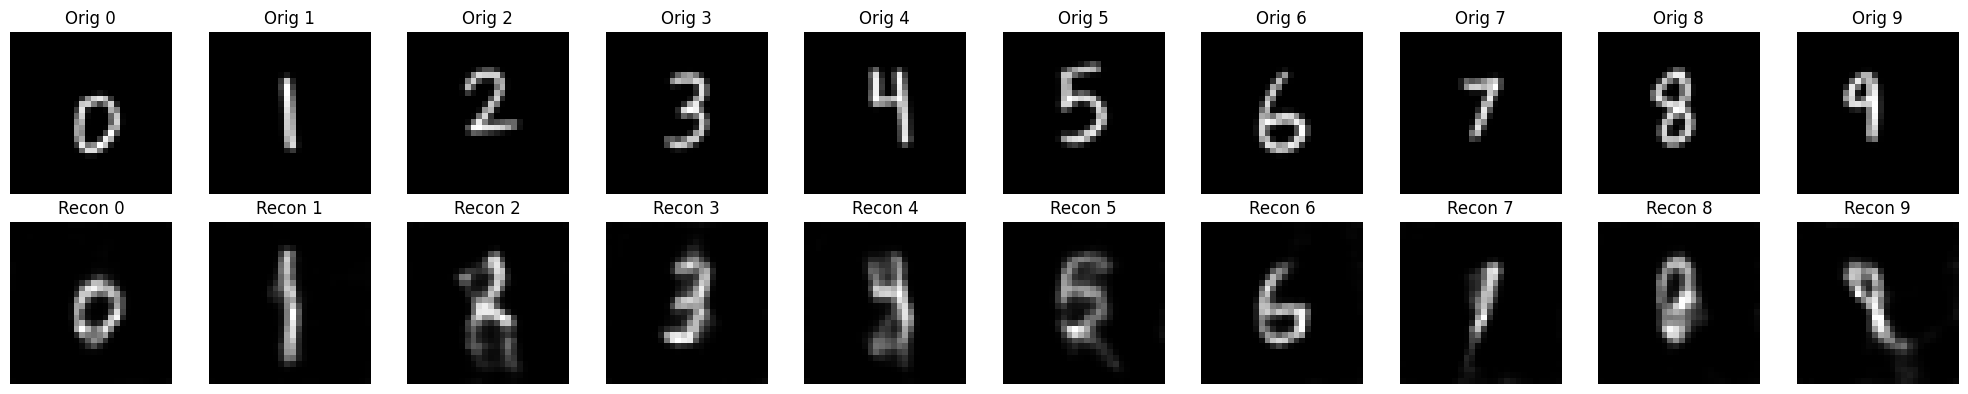

In [ ]:
import glob
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Load the trained VAE model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = VAE(latent_dim=64).to(device)

checkpoint_files = glob.glob('./checkpoints_mnist/vae_mnist_epoch_*.pth')
if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    checkpoint = torch.load(latest_checkpoint, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Loaded VAE model from {latest_checkpoint}")
else:
    print("❌ No VAE checkpoint found. Train the model first.")

model.eval()

# Normalization for MNIST (mean=0.5, std=0.5 -> [-1,1])
normalize = torchvision.transforms.Normalize((0.5,), (0.5,))
all_images = []
all_recons = []
reconstruction_losses = []

for i in range(10):
    # Load and preprocess image
    image = torchvision.io.read_image(f"../../written_images/image{i}.jpeg") / 255.0
    image = torchvision.transforms.functional.invert(image)
    image = normalize(image)
    image = torchvision.transforms.functional.rgb_to_grayscale(image, num_output_channels=1)
    image = torchvision.transforms.functional.resize(image, size=[28, 28])
    image = torchvision.transforms.functional.center_crop(image, output_size=[28, 28])
    image = image.unsqueeze(0)  # Add batch dimension: [1, 1, 28, 28]
    all_images.append(image.squeeze(0))  # Store without batch for visualization
    
    # Move to device and compute reconstruction
    image = image.to(device)
    with torch.no_grad():
        recon, mu, logvar = model(image)
        # Compute reconstruction loss (MSE)
        recon_loss = torch.nn.functional.mse_loss(recon, image, reduction='sum').item()
        reconstruction_losses.append(recon_loss)
        all_recons.append(recon.squeeze(0).cpu())  # Store reconstruction without batch
    
print("Reconstruction losses for handwritten images:", reconstruction_losses)
print("Average reconstruction loss:", np.mean(reconstruction_losses))

# For comparison, compute average reconstruction loss on a batch of MNIST test data (ID)
test_batch, _ = next(iter(test_loader))
test_batch = test_batch[:10].to(device)  # Take 10 for comparison
with torch.no_grad():
    recon_test, _, _ = model(test_batch)
    id_losses = [torch.nn.functional.mse_loss(recon_test[j], test_batch[j], reduction='sum').item() for j in range(10)]
print("Reconstruction losses for MNIST test images (ID):", id_losses)
print("Average reconstruction loss (ID):", np.mean(id_losses))

# Visualize the images: originals and reconstructions
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Original
    axes[0, i].imshow(all_images[i].squeeze(0).cpu().numpy(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Orig {i}')
    # Reconstruction
    axes[1, i].imshow(all_recons[i].squeeze(0).numpy(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Recon {i}')
plt.tight_layout()
plt.show()

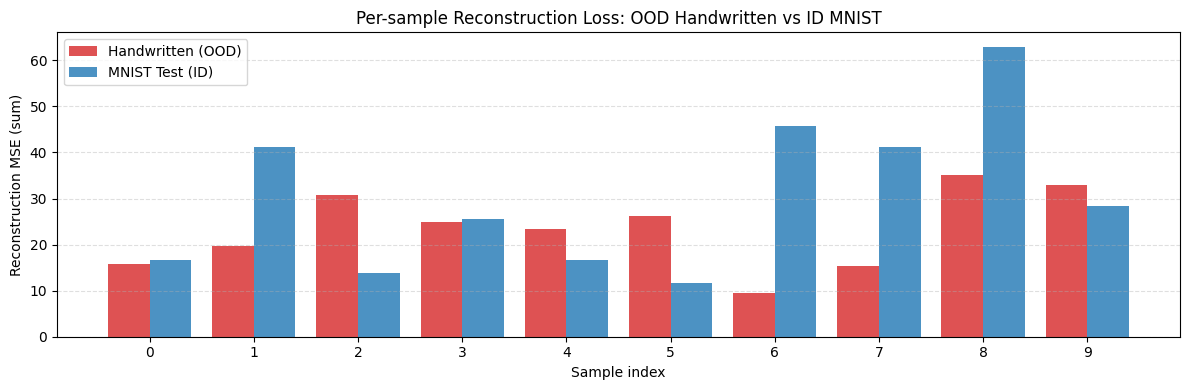

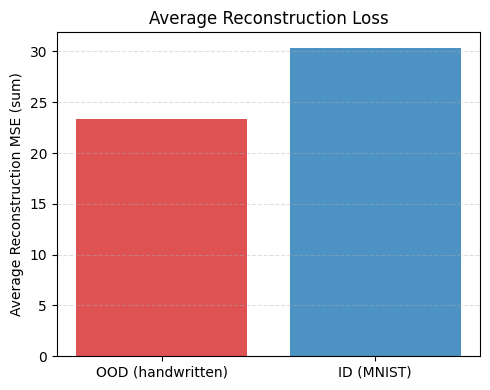

In [15]:
# --- New: Plot reconstruction losses (OOD vs ID) ---
plt.figure(figsize=(12, 4))
x = np.arange(10)
width = 0.4
plt.bar(x - width/2, reconstruction_losses, width=width, label='Handwritten (OOD)', color='#d62728', alpha=0.8)
plt.bar(x + width/2, id_losses, width=width, label='MNIST Test (ID)', color='#1f77b4', alpha=0.8)
plt.xticks(x, [str(i) for i in range(10)])
plt.xlabel('Sample index')
plt.ylabel('Reconstruction MSE (sum)')
plt.title('Per-sample Reconstruction Loss: OOD Handwritten vs ID MNIST')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Also show averages as a mini bar chart
plt.figure(figsize=(5, 4))
plt.bar(['OOD (handwritten)', 'ID (MNIST)'], [np.mean(reconstruction_losses), np.mean(id_losses)], color=['#d62728', '#1f77b4'], alpha=0.8)
plt.ylabel('Average Reconstruction MSE (sum)')
plt.title('Average Reconstruction Loss')
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()